<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/causal_method/unified_approach/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Forecasting and prediction



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


df_agg_clusters_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered.csv"
df_url = "https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/main/datasets/unified_approach/df_ma.csv"
#df_clustered_pca_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered_pca.csv"

#df = pd.read_csv(df_url)
df_agg_clusters = pd.read_csv(df_agg_clusters_url)
#df_clustered_pca = pd.read_csv(df_clustered_pca_url)


# Convert numerical columns to string
for i, curr_df in enumerate([df_agg_clusters]):
    numerical_columns = ['HOSPI_CODE_UCD']
    curr_df[numerical_columns] = curr_df[numerical_columns].astype('string')


medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [2]:
df_agg_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            4072 non-null   object 
 1   HOSPI_CODE_UCD  4072 non-null   string 
 2   LIT_HC          4072 non-null   float64
 3   LIT_HP          4072 non-null   float64
 4   N_ETB           4072 non-null   float64
 5   N_UFS           4072 non-null   float64
 6   PN_MEDICAL      4072 non-null   float64
 7   POPULATION      4072 non-null   float64
 8   P_MEDICAL       4072 non-null   float64
 9   QUANTITY        4072 non-null   float64
 10  QUANTITY_MA     4072 non-null   float64
 11  RESID           4072 non-null   float64
 12  SEASONAL        4072 non-null   float64
 13  SEJ_HAD         4072 non-null   float64
 14  SEJ_MCO         4072 non-null   float64
 15  SEJ_PSY         4072 non-null   float64
 16  SEJ_SLD         4072 non-null   float64
 17  SEJ_SSR         4072 non-null   f

In [3]:
df_agg_clusters = df_agg_clusters[df_agg_clusters['QUANTITY'] > 0]
df_agg_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            4072 non-null   object 
 1   HOSPI_CODE_UCD  4072 non-null   string 
 2   LIT_HC          4072 non-null   float64
 3   LIT_HP          4072 non-null   float64
 4   N_ETB           4072 non-null   float64
 5   N_UFS           4072 non-null   float64
 6   PN_MEDICAL      4072 non-null   float64
 7   POPULATION      4072 non-null   float64
 8   P_MEDICAL       4072 non-null   float64
 9   QUANTITY        4072 non-null   float64
 10  QUANTITY_MA     4072 non-null   float64
 11  RESID           4072 non-null   float64
 12  SEASONAL        4072 non-null   float64
 13  SEJ_HAD         4072 non-null   float64
 14  SEJ_MCO         4072 non-null   float64
 15  SEJ_PSY         4072 non-null   float64
 16  SEJ_SLD         4072 non-null   float64
 17  SEJ_SSR         4072 non-null   f

## 5.1 - New database composition based on clusters

## 5.2 - Building forecasting models based on clusters

In [3]:
def plot_pred(y_pred, y_test, medicine):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Scatter plot for y_pred
    axes[0].scatter(np.arange(len(y_pred)), y_pred, marker='o', label='Predicted', color='blue')

    # Scatter plot for y_test
    axes[0].scatter(np.arange(len(y_test)), y_test, marker='x', label='Actual', color='red')

    # Set axes labels and title
    axes[0].set_xlabel('Test samples')
    axes[0].set_ylabel('Quantity')
    axes[0].set_title(f'Predicted vs Actual: {medicine}')
    axes[0].legend()

    epsilon = 0.001
    mape_array = np.abs(y_test - y_pred) / np.maximum(epsilon, np.abs(y_test))

    # Stem plot for MAPE
    stem = axes[1].stem(np.arange(len(y_pred)), mape_array, markerfmt='bo', linefmt='b-', basefmt='r-', label='MAPE')
    axes[1].set_xlabel('Test samples')
    axes[1].set_ylabel('MAPE')
    axes[1].set_title(f'MAPE for: {medicine}')
    axes[1].set_ylim([0, 1])

    mape_target = 0.3
    axes[1].axhline(y=mape_target, color='g', linestyle='--', label=f'Target MAPE ({mape_target:.2f})')

    # Adjust layout
    plt.tight_layout()

    # Add a legend
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles=handles, labels=labels, loc='best')

    # Adjust width of subplots and margins
    fig.subplots_adjust(wspace=0.4, left=0.1, right=0.9)

    plt.show()

In [ ]:
def test_1_baseline(df, medicine, df_scores):
  print()
  print(100*'-')
  print('Medicine:' + str(medicine))

  X = df[df['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD',
                                                 'DATE', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1).values

  y = df[df['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].values

  if m.ceil(len(X) * 0.1) == 1:
    print('Dataset too small')
    test_size = 2
  else:
    test_size = 0.2

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = test_size,
                                                      random_state = 42)
  print(f'Size of data set: {len(X)}')
  print(f'Size of training set: {len(X_train)}')
  print(f'Size of test set: {len(X_test)}')

  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt', 1, 2]
  }
  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                             param_grid=param_grid,
                             scoring = 'neg_mean_absolute_percentage_error',
                             cv = 5,
                             n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''
  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best estimator
  best_estimator = grid_search.best_estimator_

  # Make predictions using the best estimator
  y_pred = best_estimator.predict(X_test)

  # Calculate R^2 score
  r2 = r2_score(y_test, y_pred)

  # Calculate MAE
  mae = mean_absolute_error(y_test, y_pred)

  # Calculate MAPE
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  # Print the best parameters, best score, and evaluation metrics
  print('Best Parameters: ', grid_search.best_params_)
  print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
  print(10*'-' + 'Test scores' + 10*'-')
  print('R^2 Score:', round(r2, 3))
  print('MAE:', round(mae, 3))
  print('MAPE:', round(mape, 3))
  print('RMSE:', round(rmse, 3))
  print()


  # Create the new row as a DataFrame
  new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                          'R2': [r2],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'MAPE': [mape]})

  # Append the new row to the DataFrame
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)

  # plot pred x test
  plot_pred(y_pred, y_test, medicine)
  print()
  plt.close()



  # Return the updated DataFrame
  return df_scores



----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Size of data set: 171
Size of training set: 136
Size of test set: 35
Size of grid search: 72
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 12}
Training Score (MAPE):  -4.676
----------Test scores----------
R^2 Score: 0.715
MAE: 717.648
MAPE: 2.592
RMSE: 1173.791



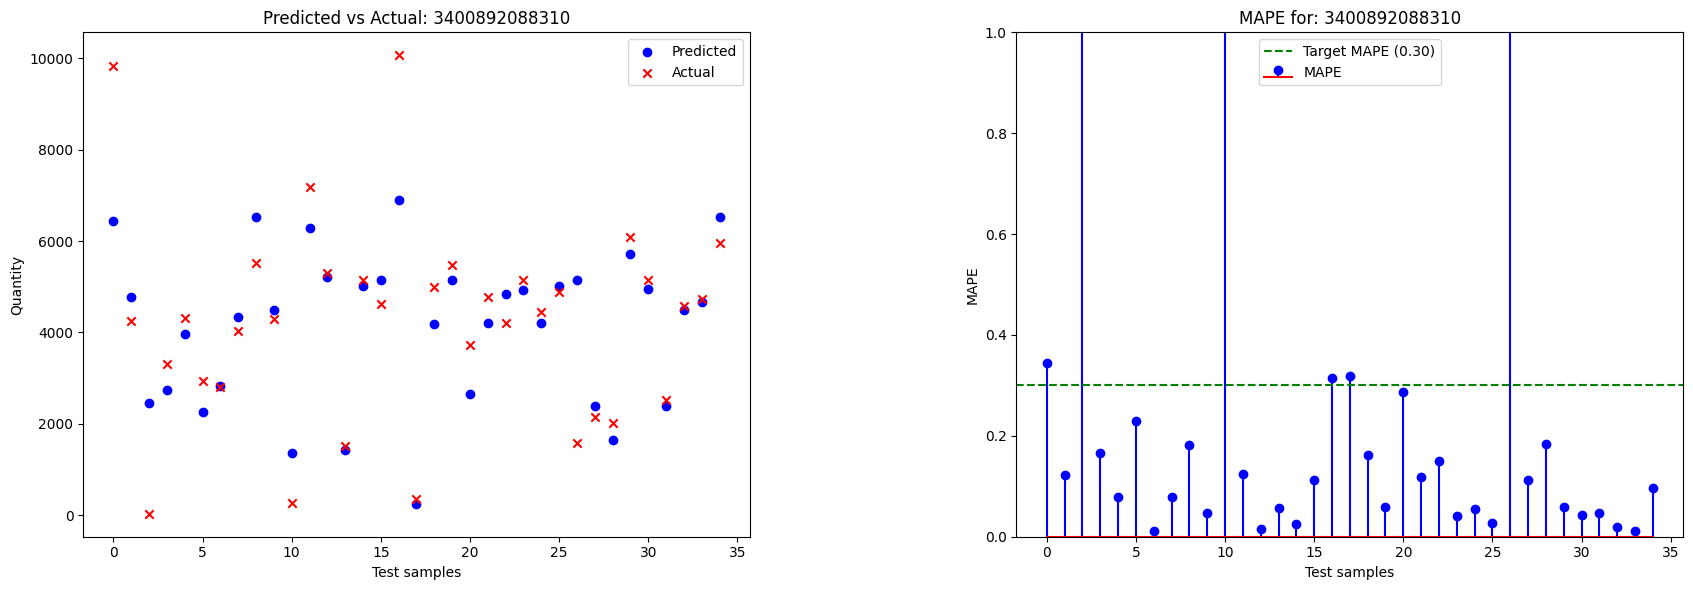



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Size of data set: 204
Size of training set: 163
Size of test set: 41
Size of grid search: 90
Best Parameters:  {'max_depth': 6, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -0.828
----------Test scores----------
R^2 Score: 0.766
MAE: 758.66
MAPE: 0.642
RMSE: 1589.706



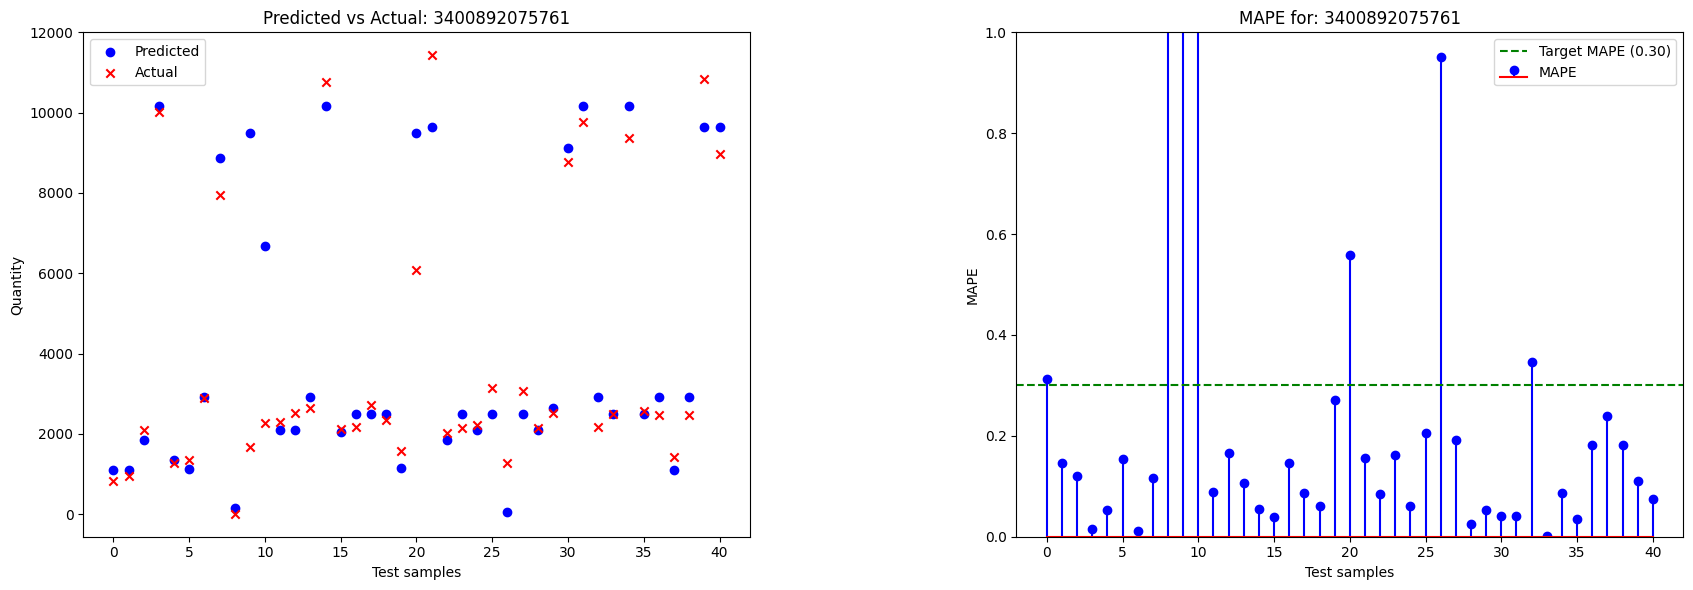



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Size of data set: 200
Size of training set: 160
Size of test set: 40
Size of grid search: 84
Best Parameters:  {'max_depth': 5, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -0.706
----------Test scores----------
R^2 Score: 0.671
MAE: 1131.702
MAPE: 1.349
RMSE: 1857.042



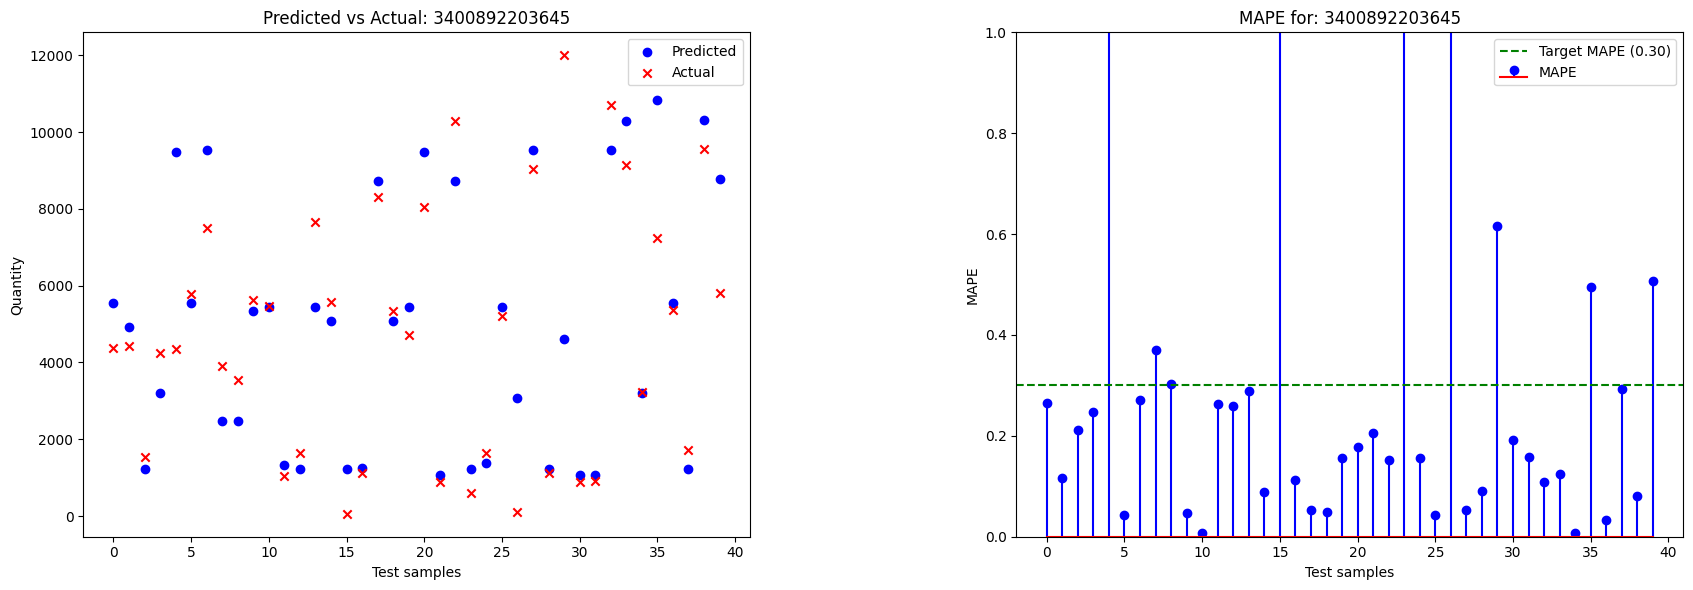



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Size of data set: 201
Size of training set: 160
Size of test set: 41
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -1.083
----------Test scores----------
R^2 Score: 0.903
MAE: 1135.841
MAPE: 0.287
RMSE: 1814.495



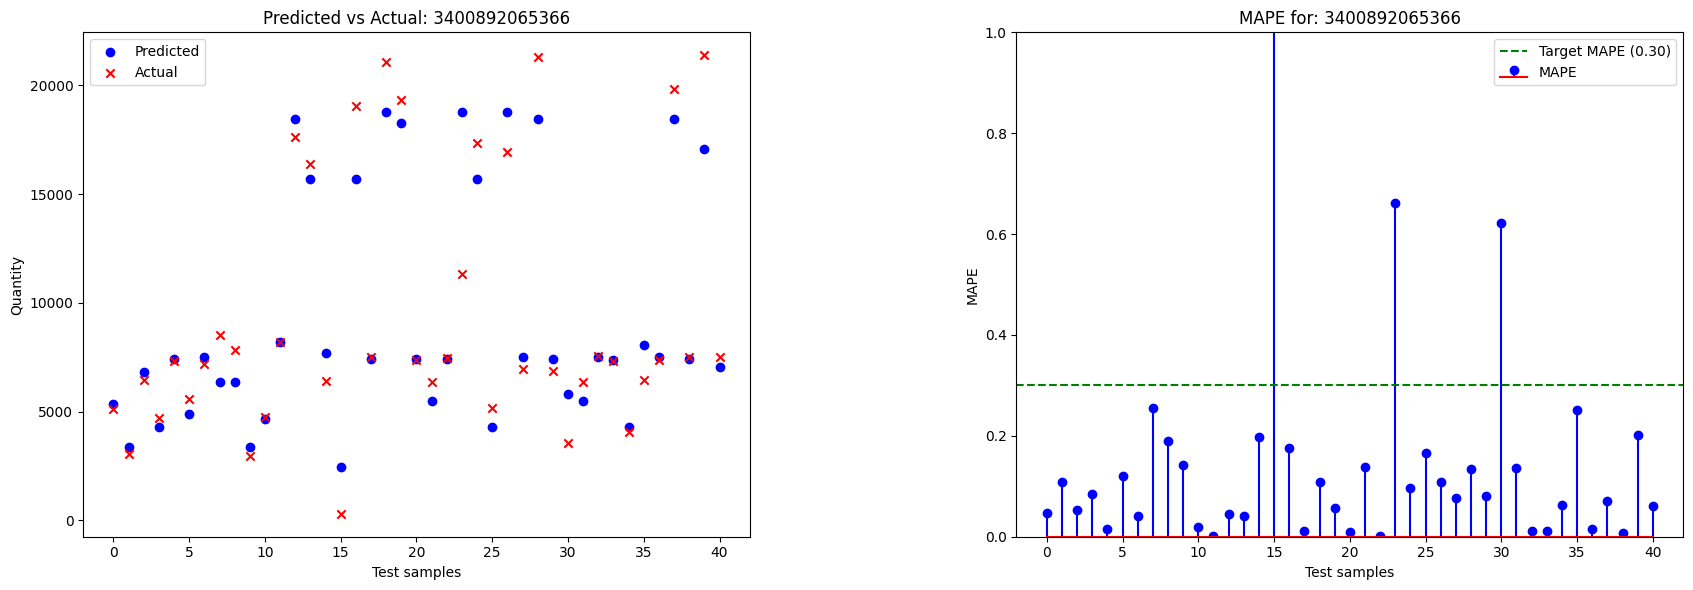



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Size of data set: 195
Size of training set: 156
Size of test set: 39
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 15}
Training Score (MAPE):  -1.81
----------Test scores----------
R^2 Score: 0.868
MAE: 675.764
MAPE: 5.87
RMSE: 1165.363



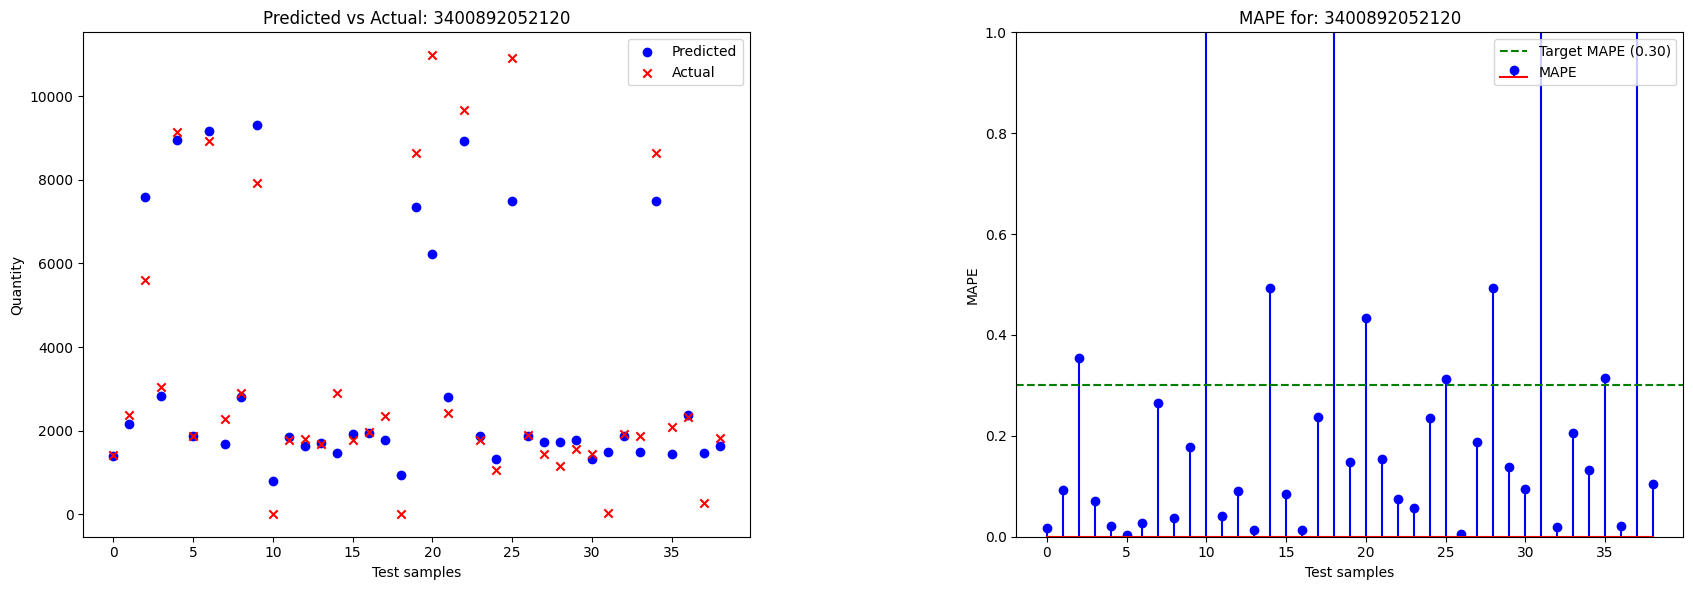



----------------------------------------------------------------------------------------------------
Medicine:3400891996128
Size of data set: 205
Size of training set: 164
Size of test set: 41
Size of grid search: 90
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 16}
Training Score (MAPE):  -5.815
----------Test scores----------
R^2 Score: 0.942
MAE: 9022.993
MAPE: 28.48
RMSE: 13460.179



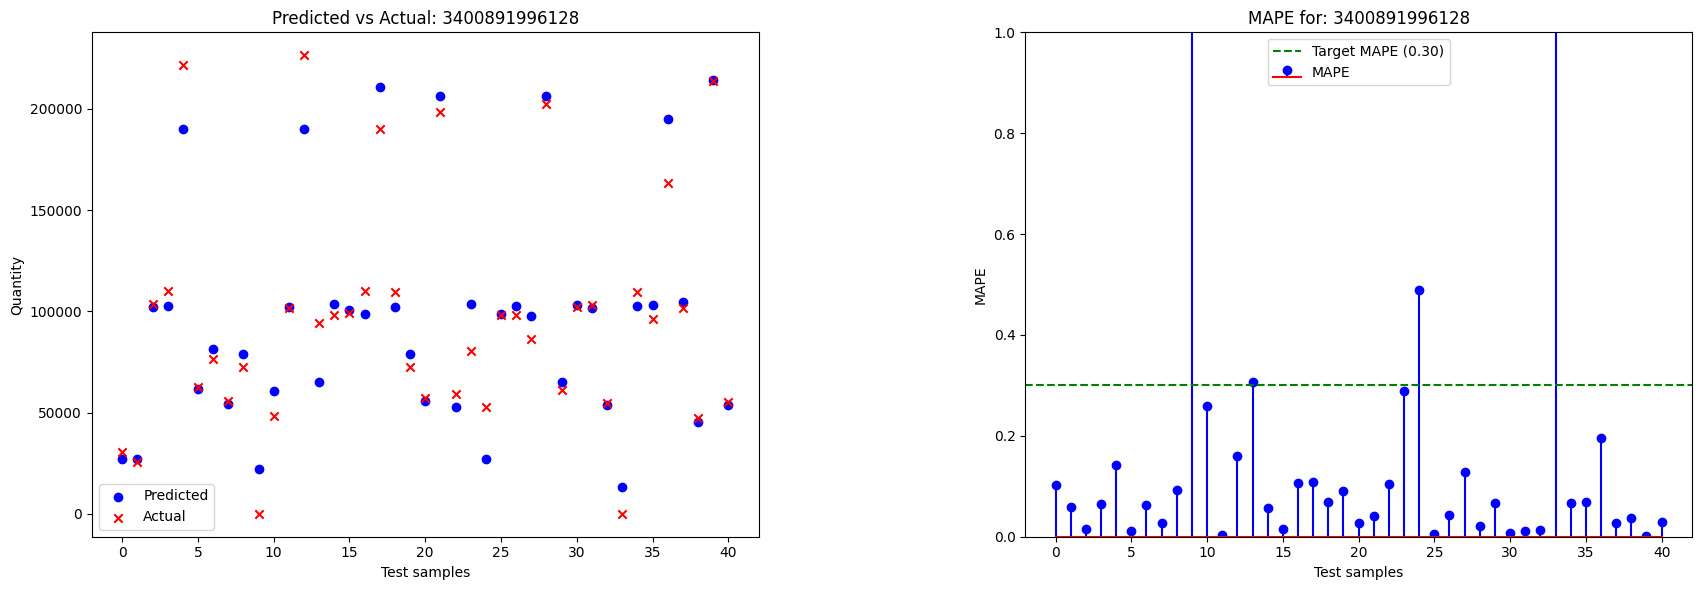



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Size of data set: 201
Size of training set: 160
Size of test set: 41
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 11}
Training Score (MAPE):  -0.678
----------Test scores----------
R^2 Score: 0.856
MAE: 795.081
MAPE: 74.648
RMSE: 1046.653



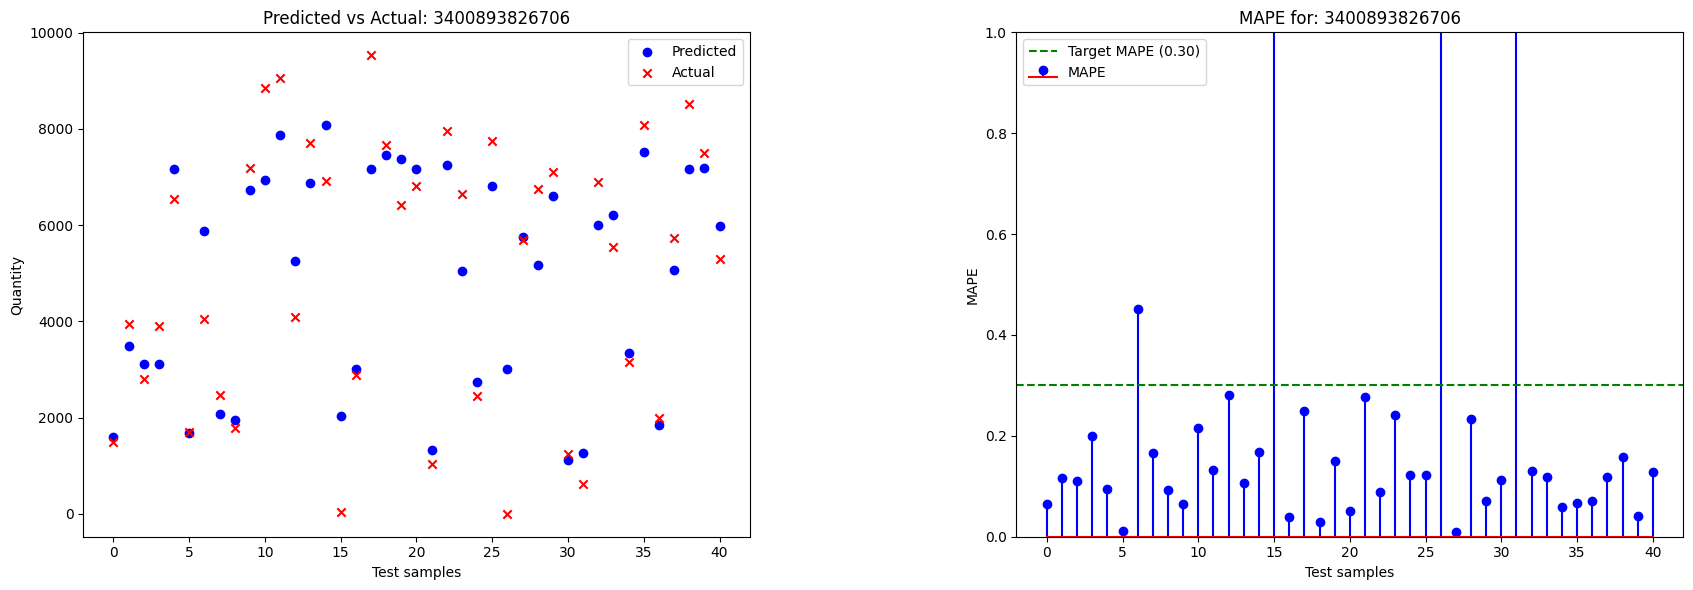



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Size of data set: 197
Size of training set: 157
Size of test set: 40
Size of grid search: 84
Best Parameters:  {'max_depth': 5, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -0.259
----------Test scores----------
R^2 Score: 0.826
MAE: 638.434
MAPE: 0.481
RMSE: 852.815



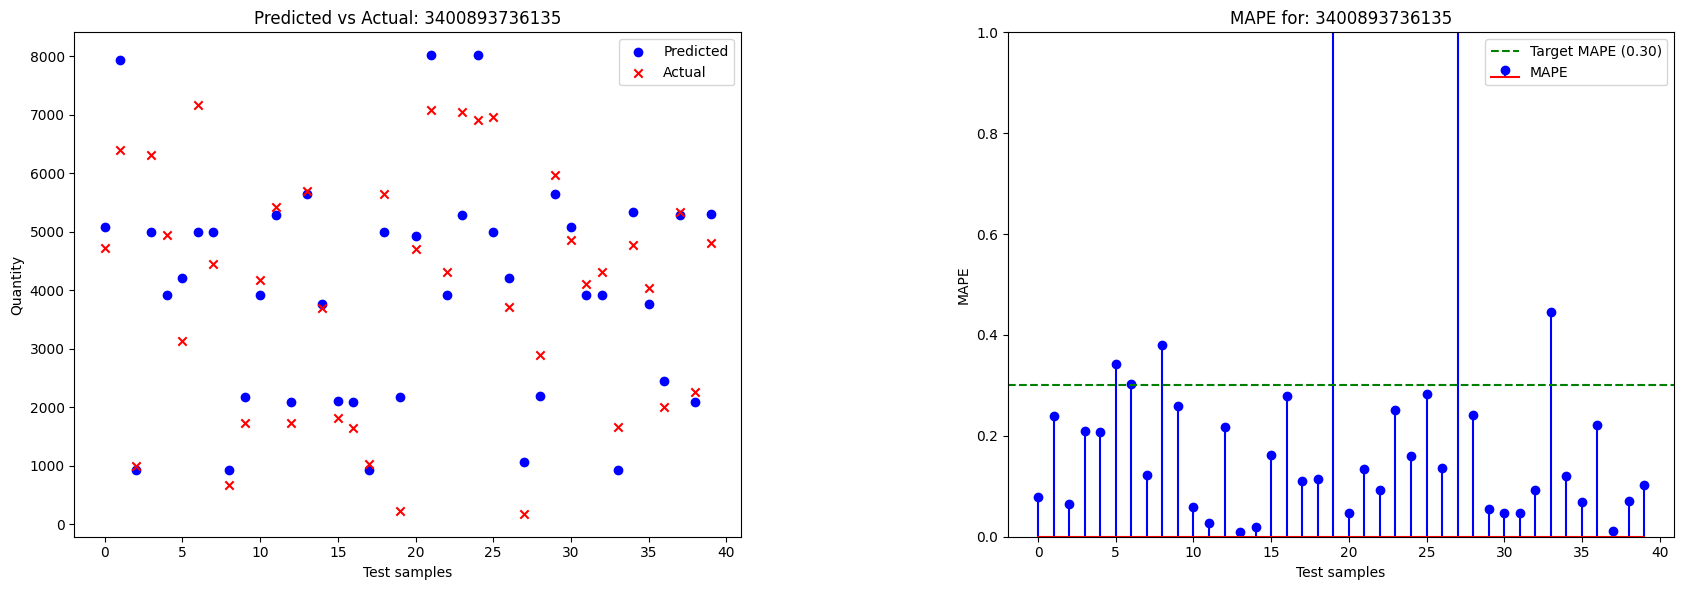



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Size of data set: 201
Size of training set: 160
Size of test set: 41
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -0.708
----------Test scores----------
R^2 Score: 0.796
MAE: 2113.851
MAPE: 11.842
RMSE: 3127.66



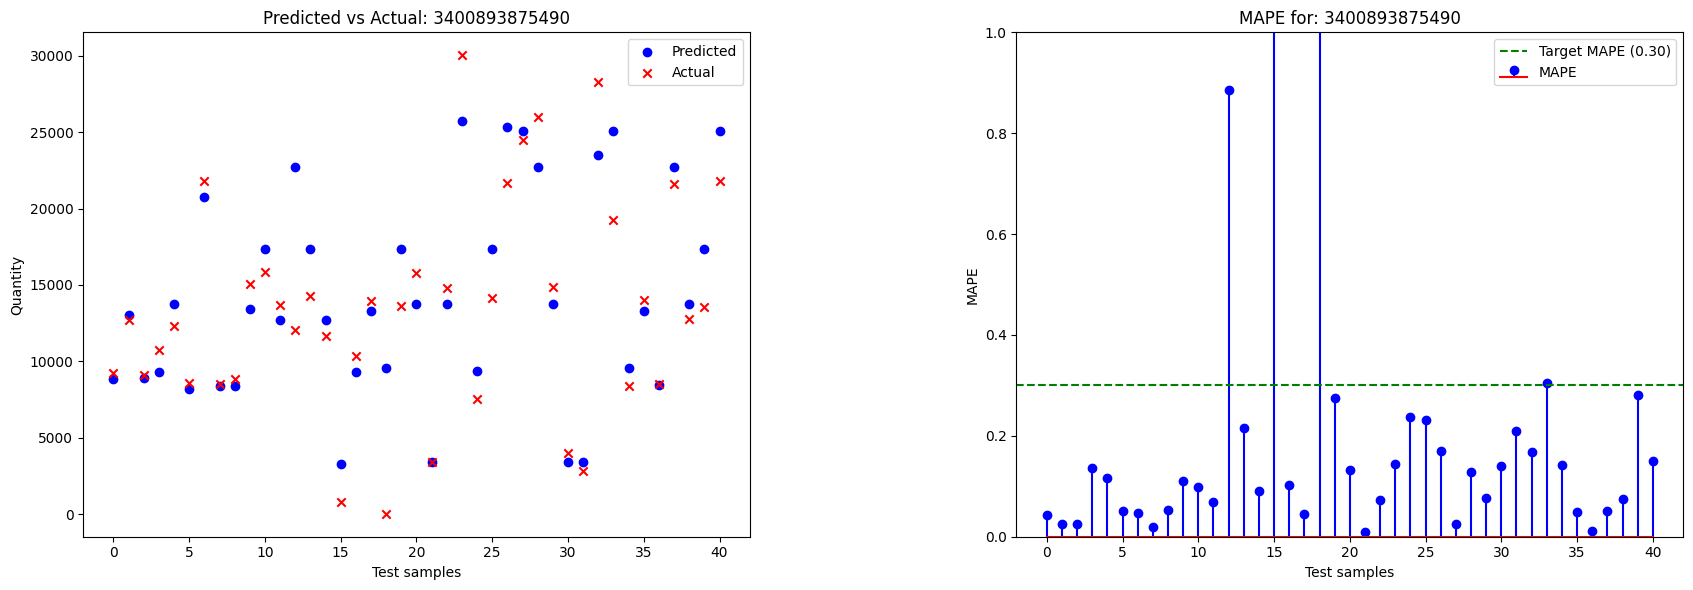



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Size of data set: 207
Size of training set: 165
Size of test set: 42
Size of grid search: 90
Best Parameters:  {'max_depth': 6, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -1.553
----------Test scores----------
R^2 Score: 0.915
MAE: 782.372
MAPE: 0.579
RMSE: 1288.081



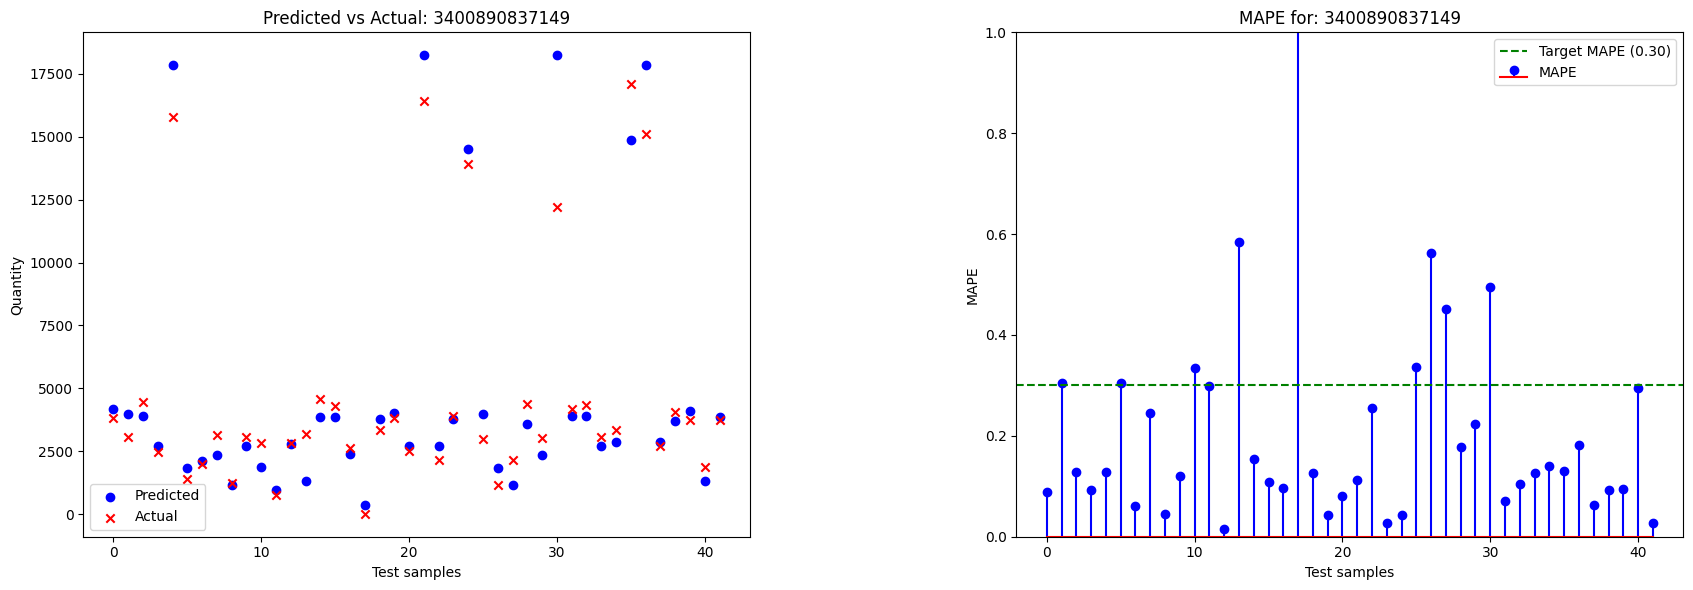



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Size of data set: 188
Size of training set: 150
Size of test set: 38
Size of grid search: 78
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 4}
Training Score (MAPE):  -1.477
----------Test scores----------
R^2 Score: 0.859
MAE: 533.999
MAPE: 2.407
RMSE: 962.587



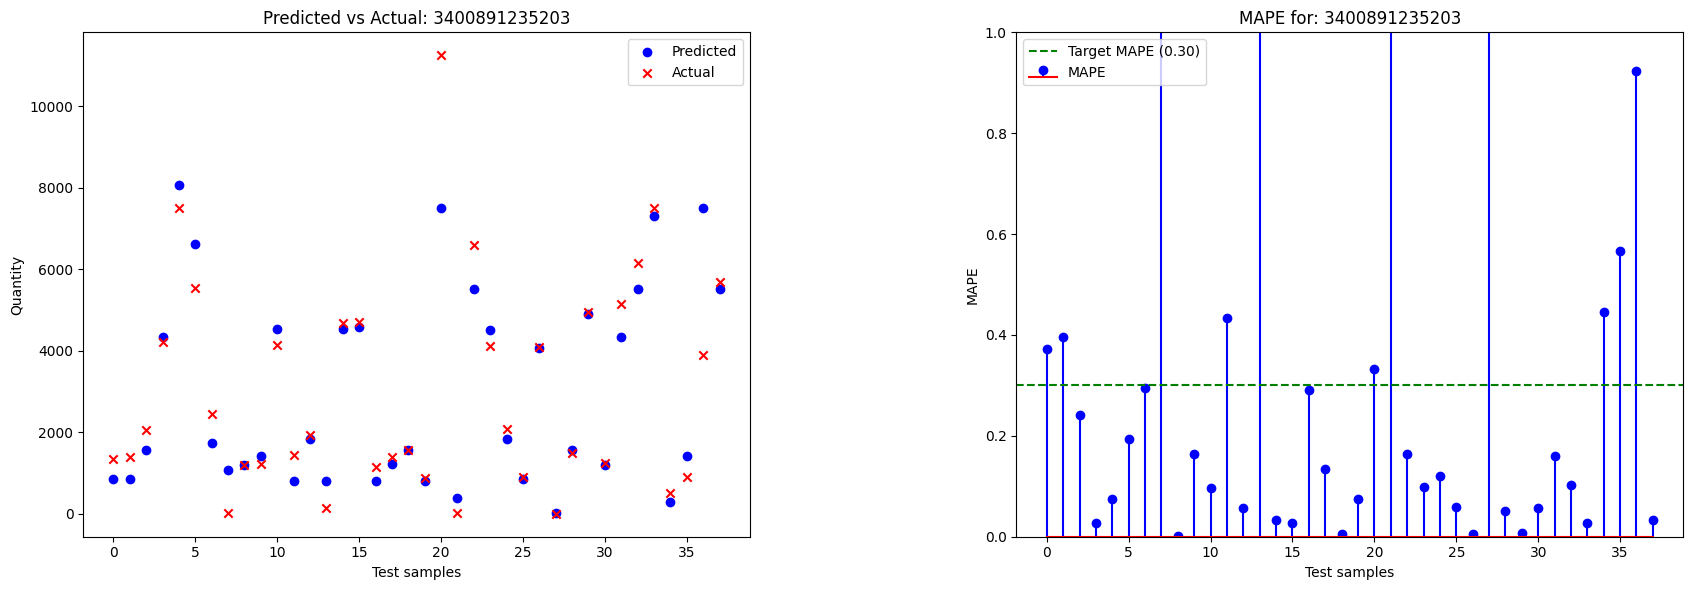



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Size of data set: 209
Size of training set: 167
Size of test set: 42
Size of grid search: 90
Best Parameters:  {'max_depth': 6, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -2.966
----------Test scores----------
R^2 Score: 0.731
MAE: 2559.608
MAPE: 3.337
RMSE: 3464.788



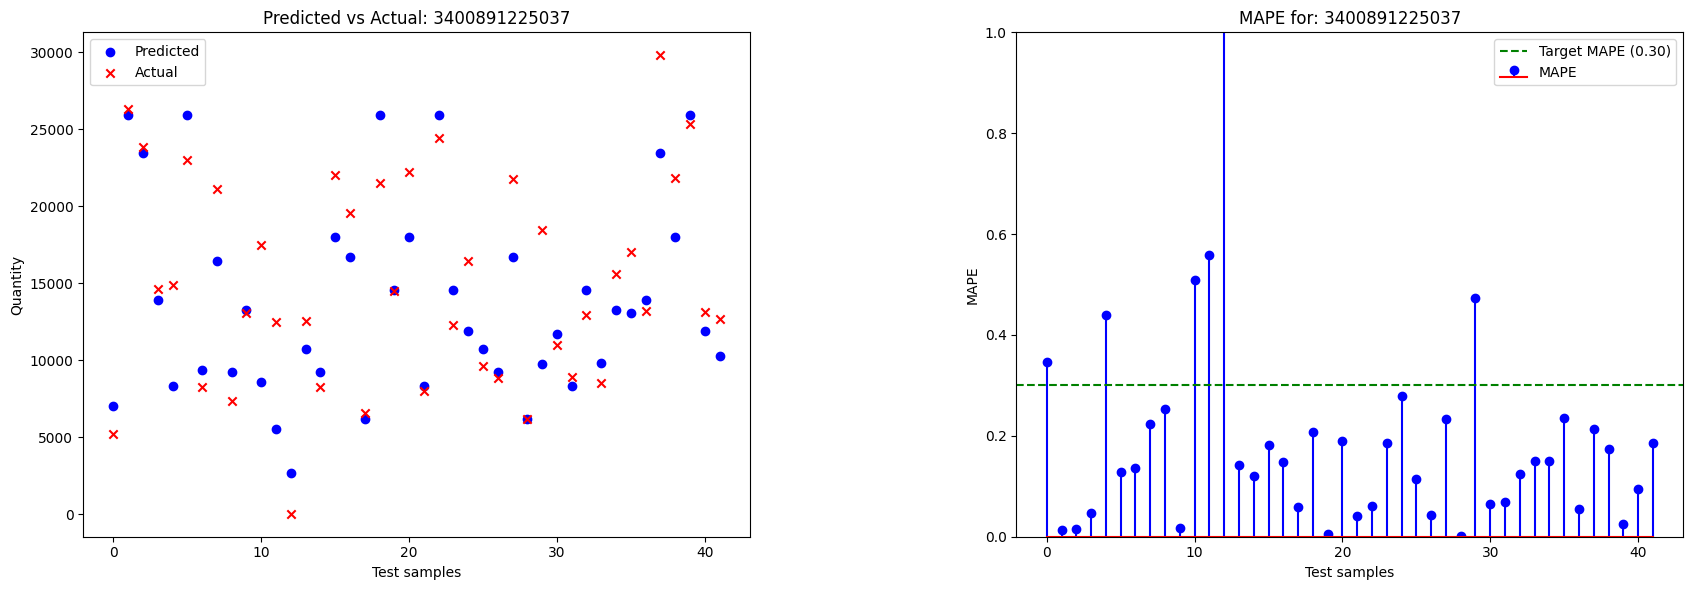



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Size of data set: 200
Size of training set: 160
Size of test set: 40
Size of grid search: 84
Best Parameters:  {'max_depth': 6, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -0.871
----------Test scores----------
R^2 Score: 0.841
MAE: 771.785
MAPE: 0.394
RMSE: 1078.821



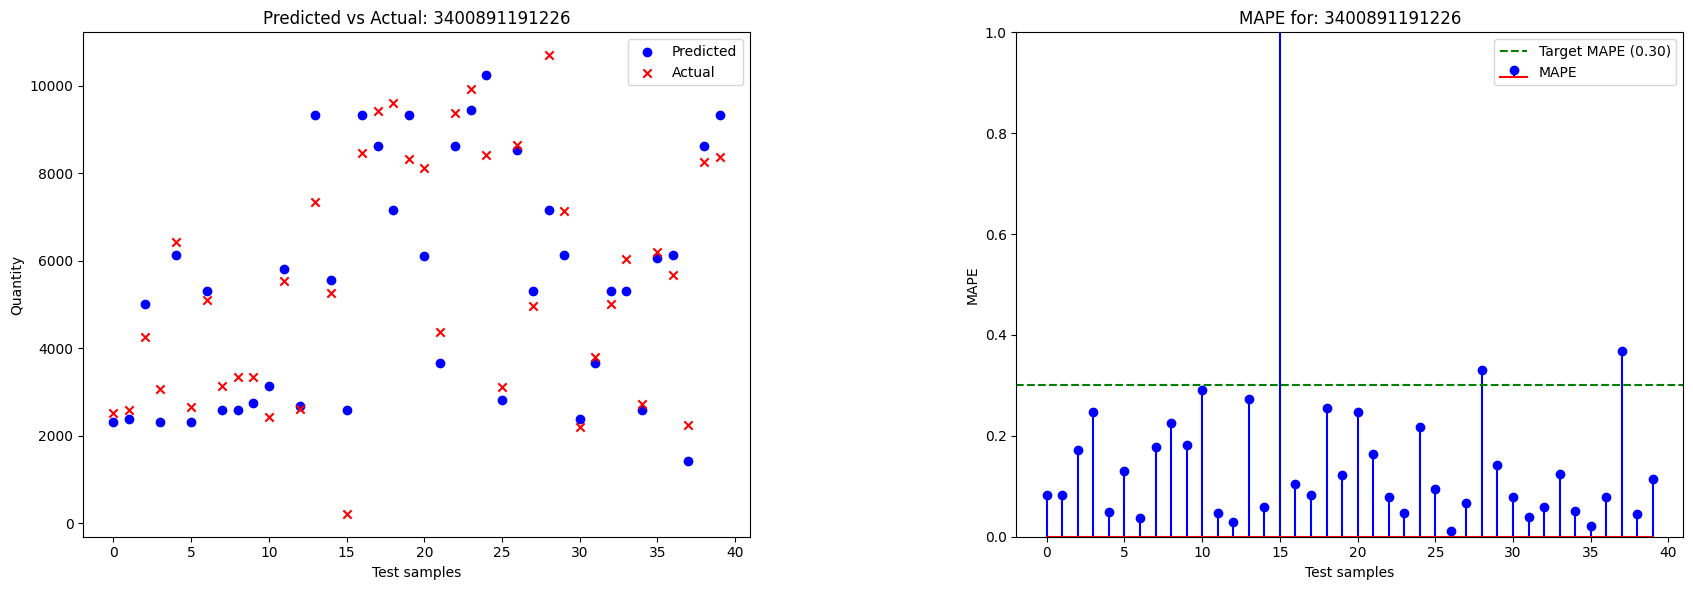



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Size of data set: 194
Size of training set: 155
Size of test set: 39
Size of grid search: 84
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 3}
Training Score (MAPE):  -0.403
----------Test scores----------
R^2 Score: 0.818
MAE: 1750.074
MAPE: 11.186
RMSE: 2832.218



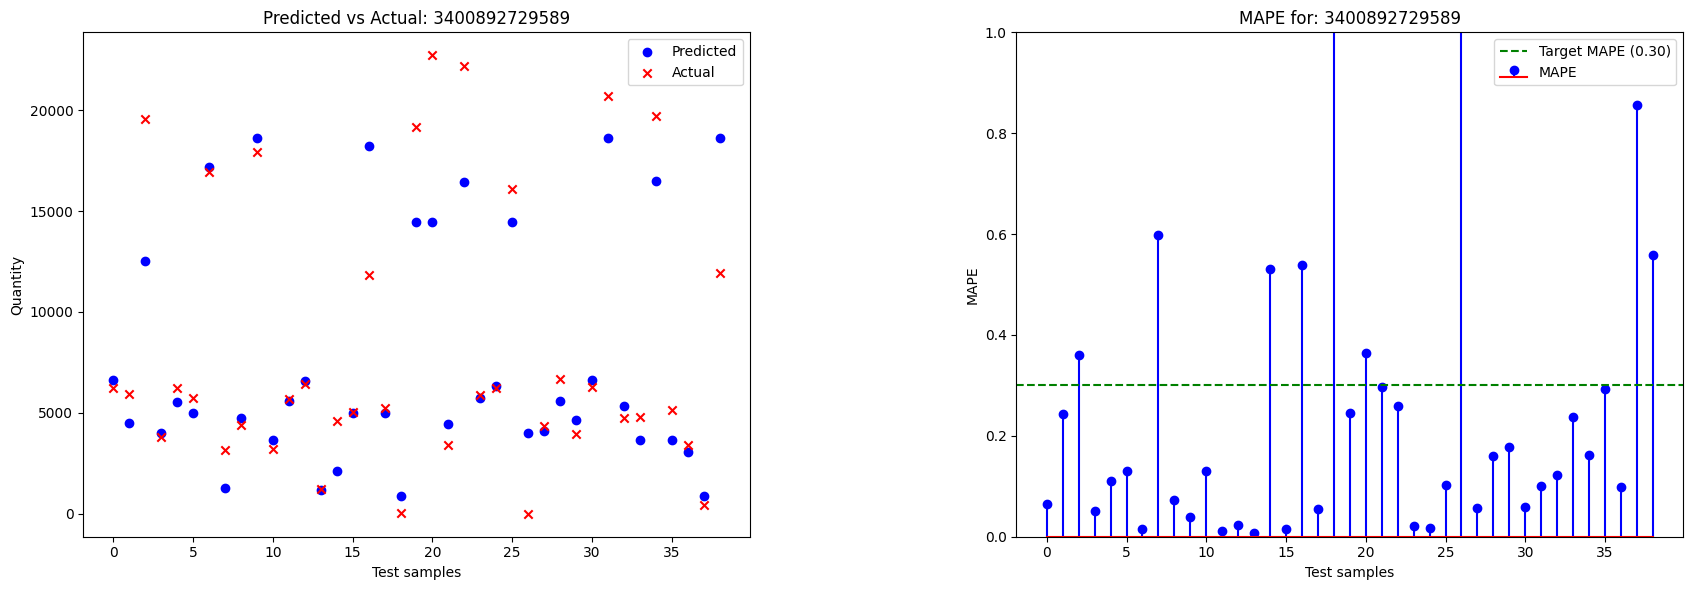



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Size of data set: 175
Size of training set: 140
Size of test set: 35
Size of grid search: 72
Best Parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -0.317
----------Test scores----------
R^2 Score: 0.695
MAE: 1371.383
MAPE: 6.99
RMSE: 2258.903



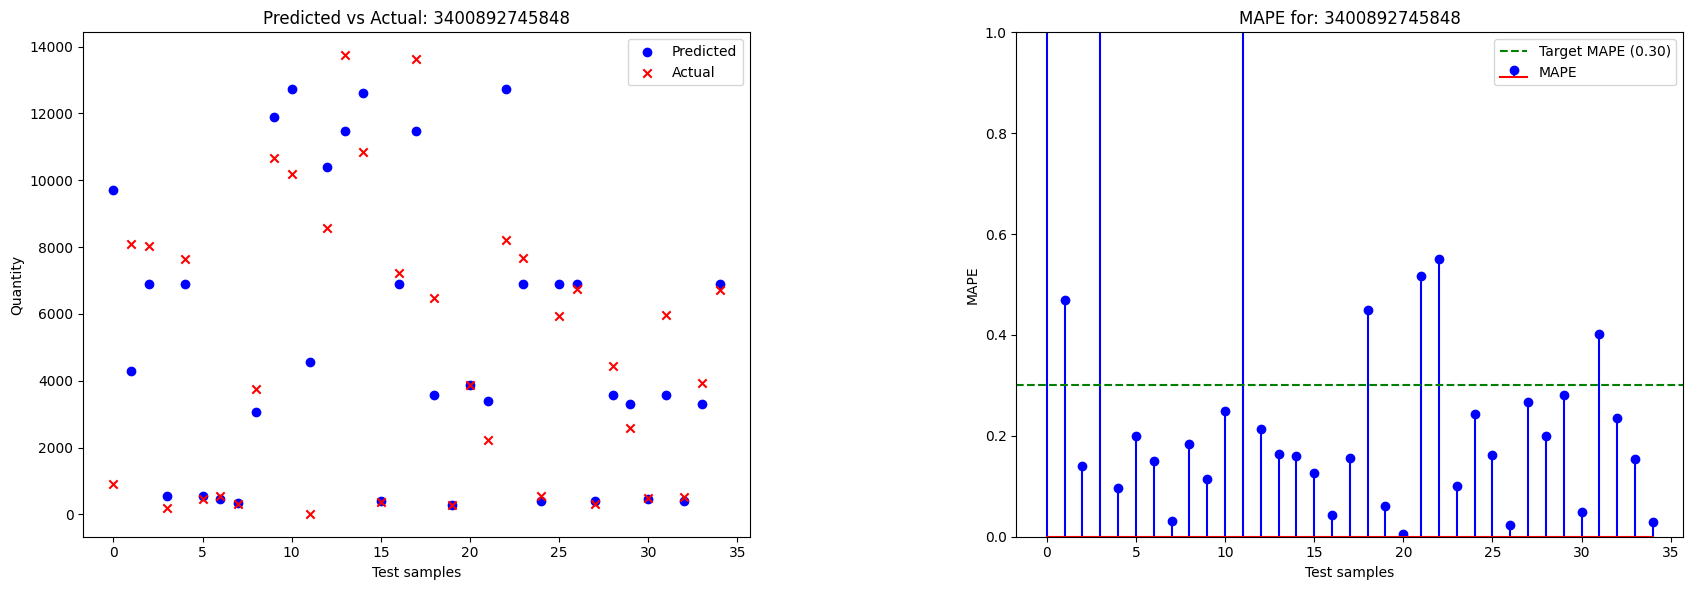



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Size of data set: 204
Size of training set: 163
Size of test set: 41
Size of grid search: 90
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 8}
Training Score (MAPE):  -0.912
----------Test scores----------
R^2 Score: 0.871
MAE: 628.286
MAPE: 1.539
RMSE: 1430.615



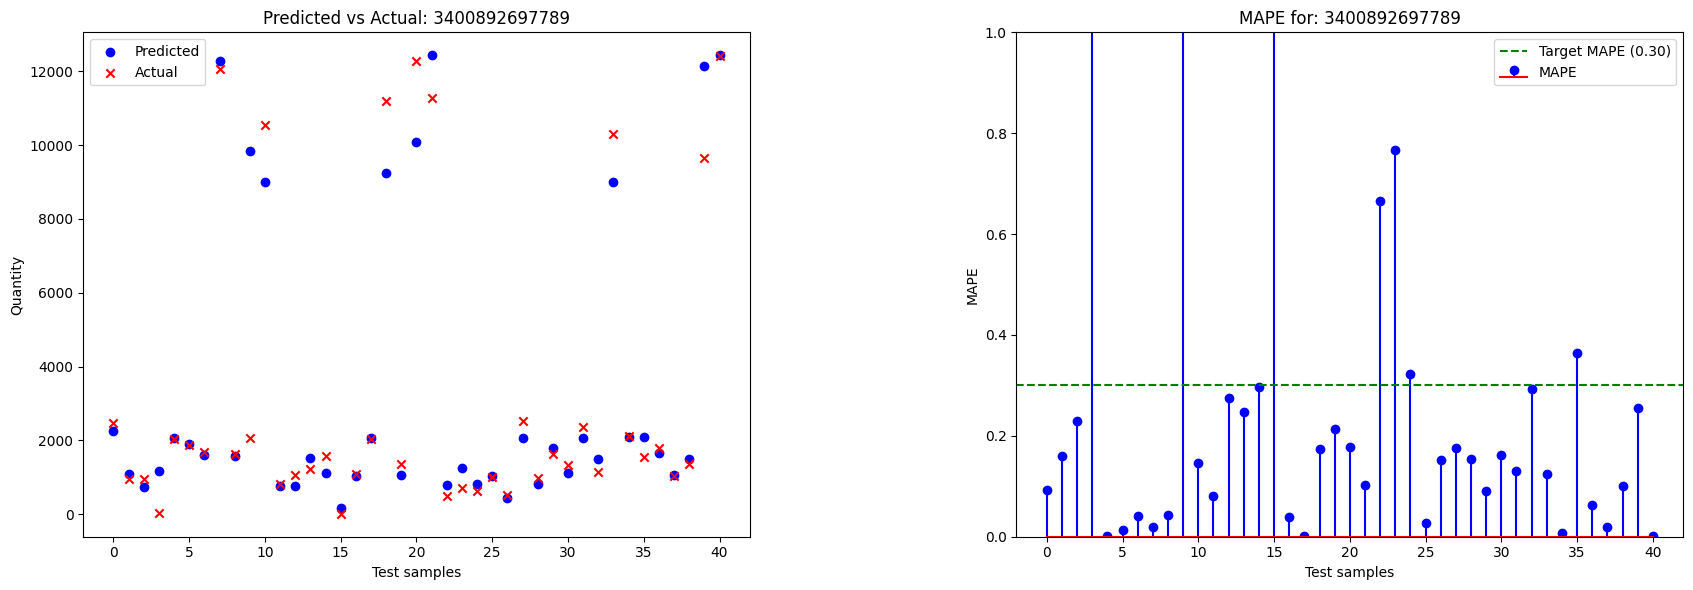



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Size of data set: 200
Size of training set: 160
Size of test set: 40
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -0.404
----------Test scores----------
R^2 Score: 0.956
MAE: 1612.585
MAPE: 7.023
RMSE: 2359.644



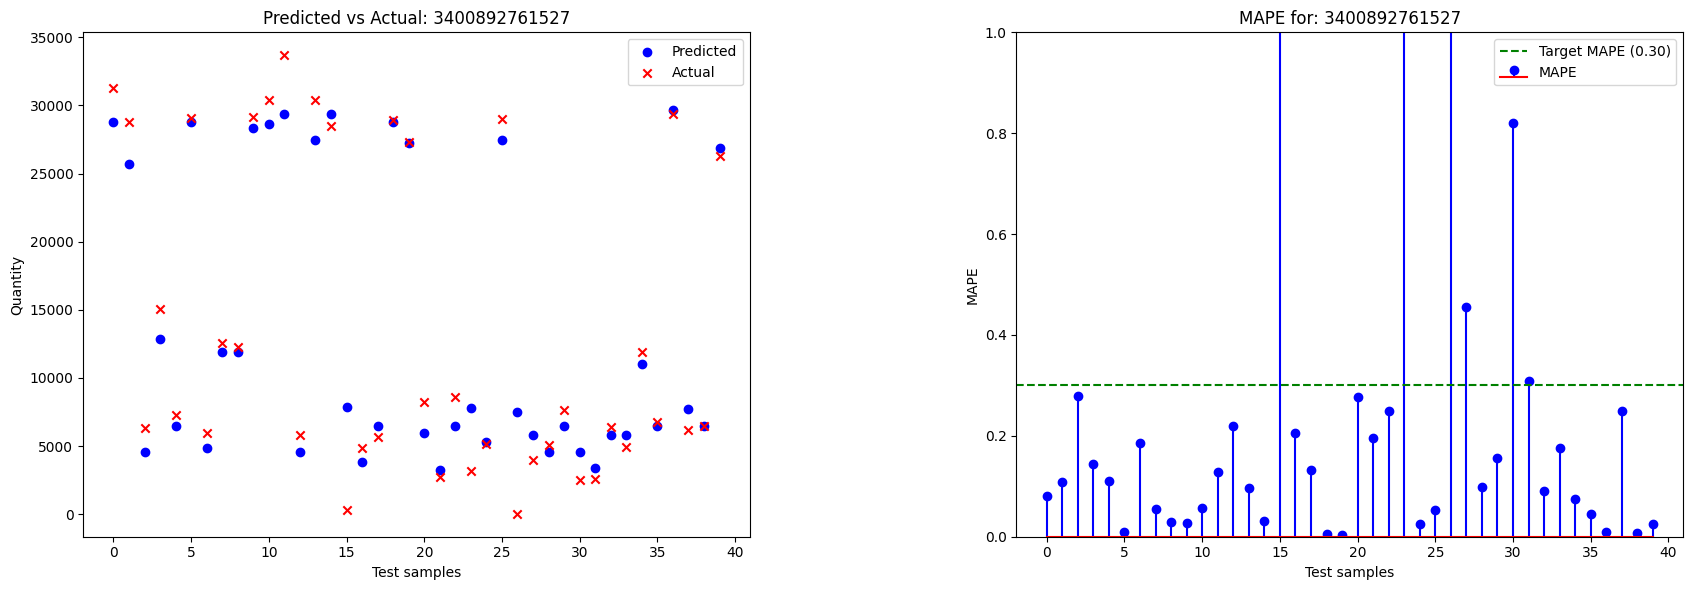



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Size of data set: 156
Size of training set: 124
Size of test set: 32
Size of grid search: 66
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -10.375
----------Test scores----------
R^2 Score: 0.504
MAE: 822.279
MAPE: 26.69
RMSE: 1192.567



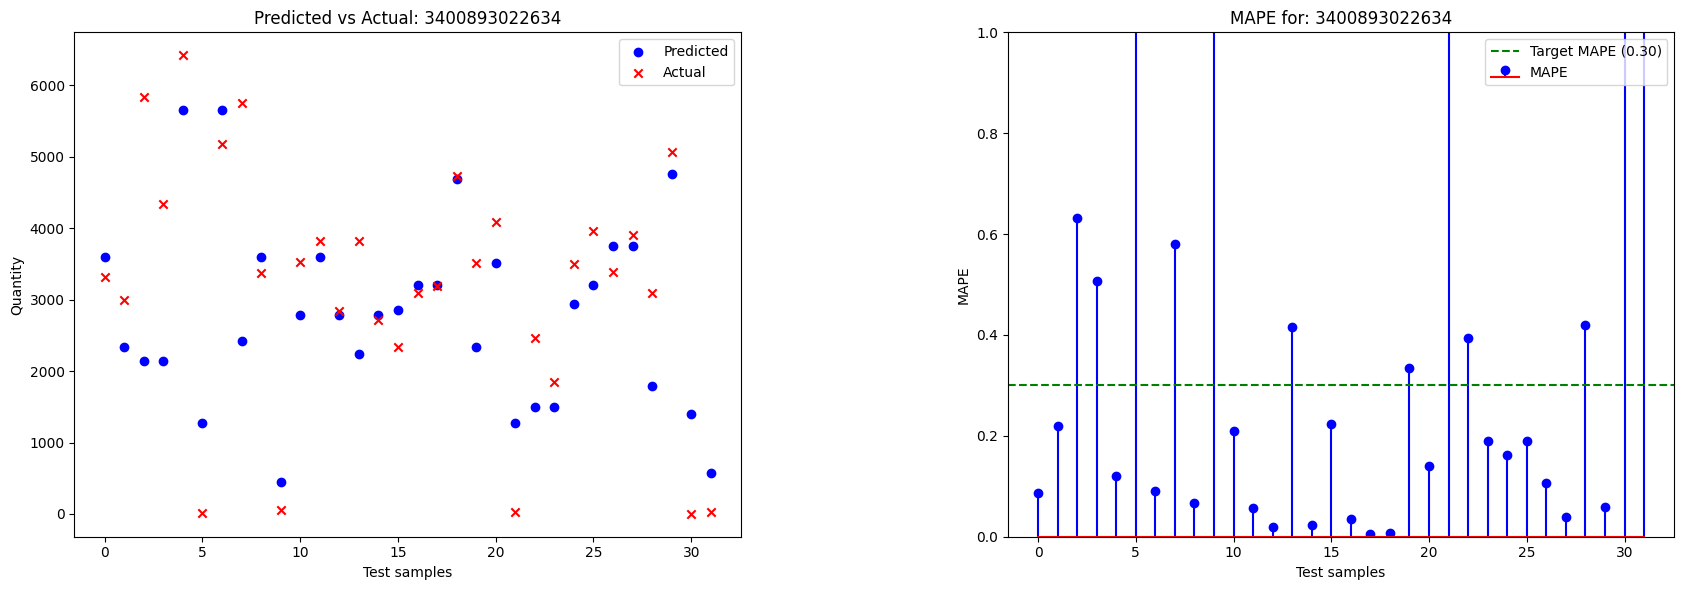



----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Size of data set: 201
Size of training set: 160
Size of test set: 41
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 13}
Training Score (MAPE):  -3.095
----------Test scores----------
R^2 Score: 0.983
MAE: 960.126
MAPE: 1.816
RMSE: 1254.697



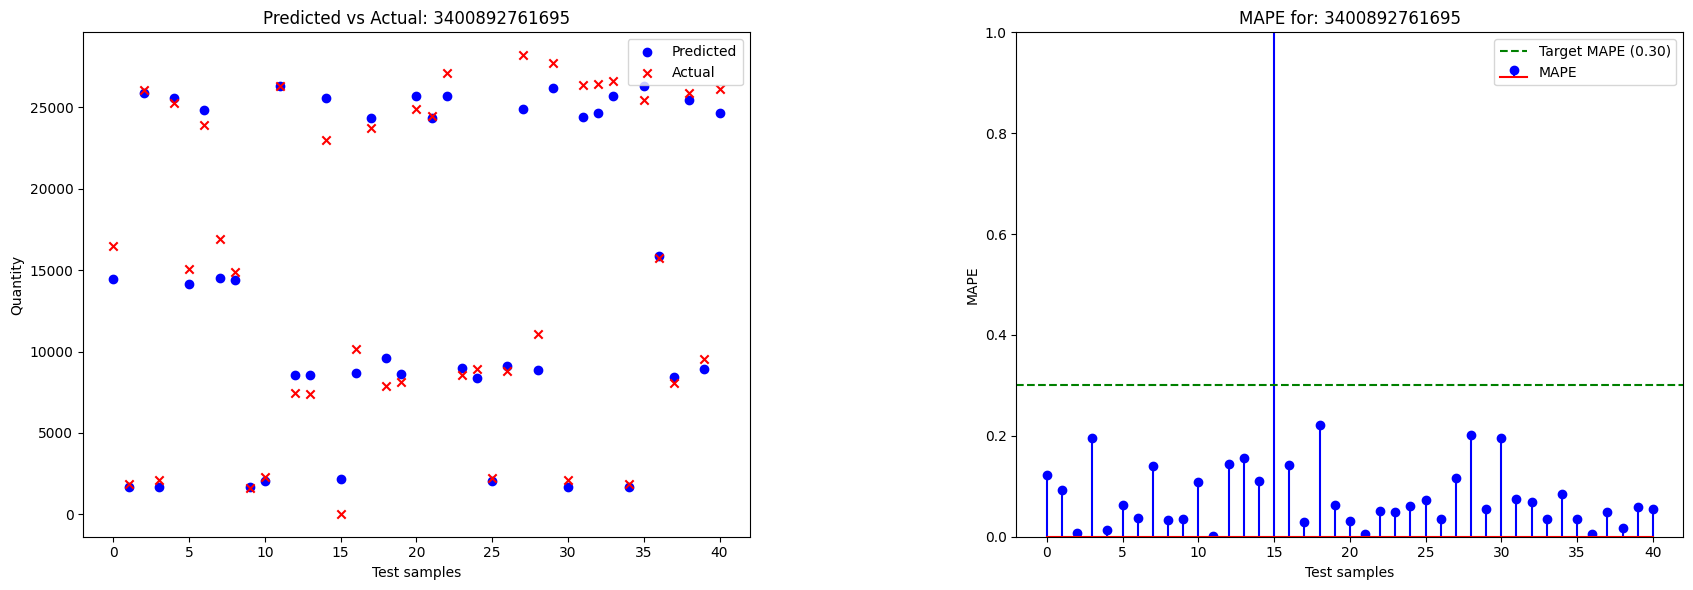



----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Size of data set: 173
Size of training set: 138
Size of test set: 35
Size of grid search: 72
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -13.046
----------Test scores----------
R^2 Score: 0.721
MAE: 1644.304
MAPE: 0.11
RMSE: 3315.27



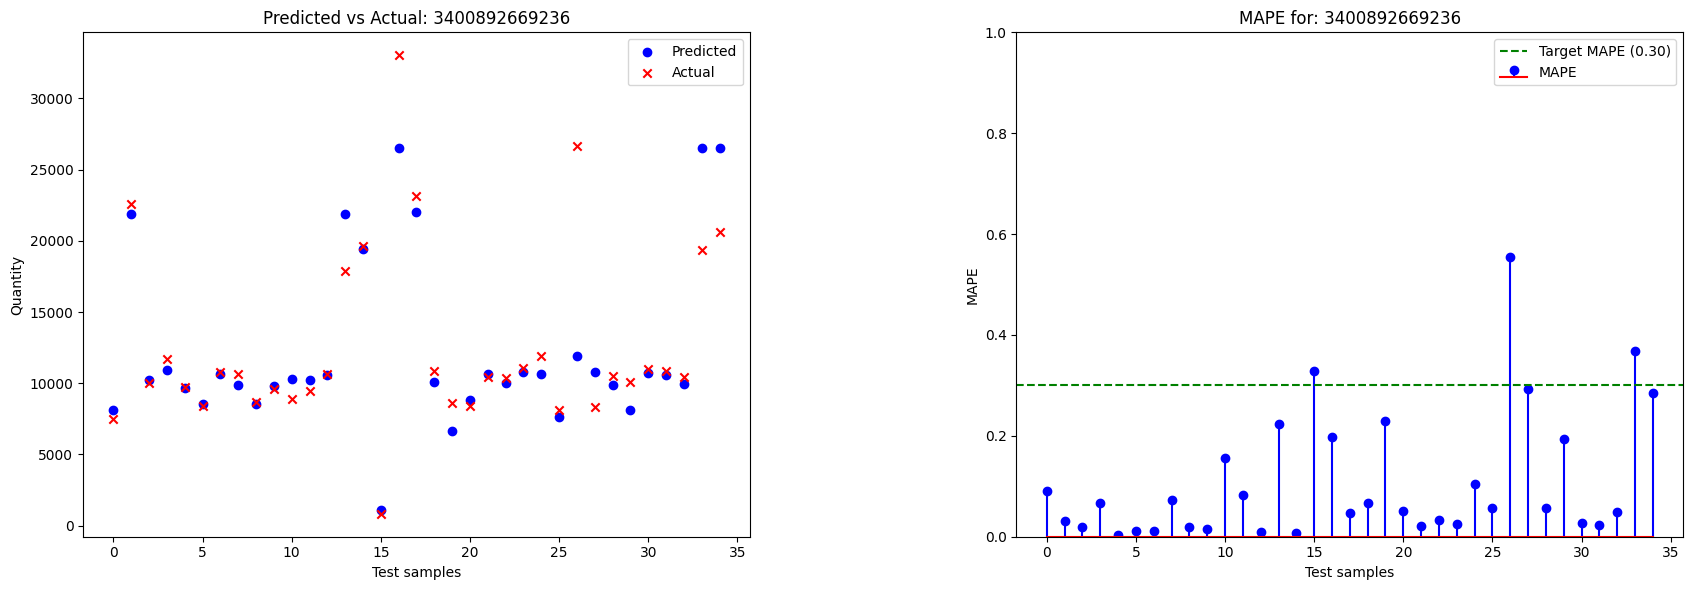



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Size of data set: 190
Size of training set: 152
Size of test set: 38
Size of grid search: 84
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.962
----------Test scores----------
R^2 Score: 0.635
MAE: 910.911
MAPE: 0.39
RMSE: 1489.258



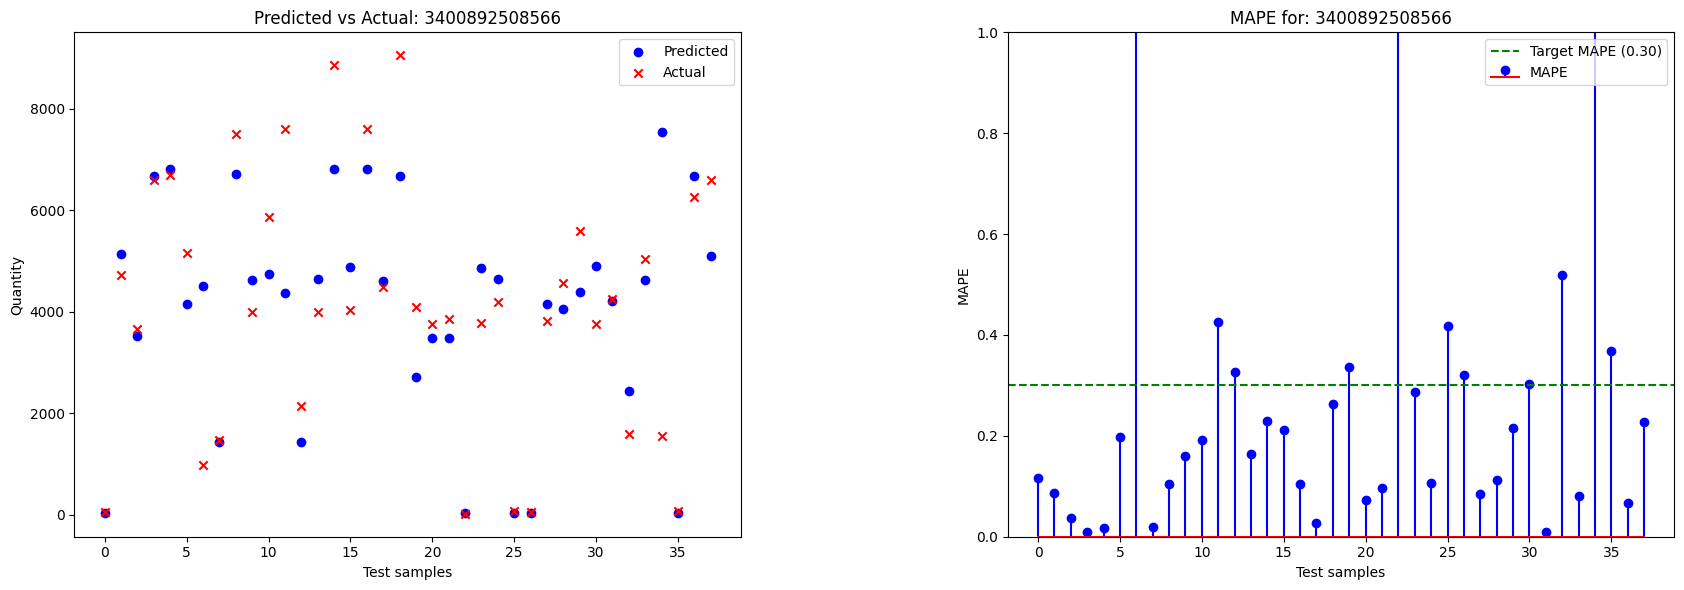

,HOSPI_CODE_UCD,R2,RMSE,MAE,MAPE
0,CODE_UCD_3400892088310,0.715172,1173.790651,717.647697,2.592467
1,CODE_UCD_3400892075761,0.766448,1589.706175,758.660384,0.642235
2,CODE_UCD_3400892203645,0.671272,1857.042493,1131.701867,1.348969
3,CODE_UCD_3400892065366,0.902731,1814.495182,1135.841006,0.286776
4,CODE_UCD_3400892052120,0.868149,1165.362598,675.764290,5.869769
5,CODE_UCD_3400891996128,0.942464,13460.179151,9022.993417,28.479933
6,CODE_UCD_3400893826706,0.856334,1046.652803,795.081390,74.648296
7,CODE_UCD_3400893736135,0.826454,852.815436,638.434217,0.481086
8,CODE_UCD_3400893875490,0.795698,3127.660261,2113.851226,11.841907
9,CODE_UCD_3400890837149,0.914592,1288.081400,782.371541,0.579432


In [ ]:
'''df_prediction_scores = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

for medicine in medicines:
  df_prediction_scores = test_1_baseline(df, medicine, df_prediction_scores)

df_prediction_scores'''

In [6]:
def test_2_clustering(df, df_scores, medicines):

  for cluster in df.CLUSTER.unique():
    print()
    print(100*'-')
    print(f'Cluster: {cluster}')

    # Perform the train-test split with shuffled samples
    X = df[df['CLUSTER'] == cluster].drop(['DATE', 'QUANTITY', 'CLUSTER', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1).copy().values
    y = df[df['CLUSTER'] == cluster]['QUANTITY'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.15, shuffle = True)
    print(f'Size of data set: {len(X_train) + len(X_test)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

    df_test = pd.DataFrame(X_test, columns = df.drop(['DATE', 'QUANTITY', 'CLUSTER', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1).copy().columns)
    df_test['QUANTITY'] = y_test


    # Define the parameter distributions for RandomizedSearchCV
    param_grid = {
        'max_depth': np.arange(2, 8, 1),
        'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
        'max_features': ['sqrt', 1, 2]
    }

    depth_len = param_grid['max_depth'].size
    estimators_len = param_grid['n_estimators'].size

    print(f'Size of grid search: {depth_len * estimators_len}')

    # Create the RandomizedSearchCV object
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid,
                              scoring = 'neg_mean_absolute_percentage_error',
                              cv = 5,
                              n_jobs = -1)

    ''' >3 : the fold and candidate parameter indexes
        are also displayed together with the starting time of the computation.
    '''


    # Fit the RandomizedSearchCV object to the data
    grid_search.fit(X_train[:,1:], y_train)

    print("Finished training")

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    for medicine in df_test.HOSPI_CODE_UCD.unique():
      print()
      print(100*'-')
      print('Medicine:' + str(medicine))

      X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD'], axis=1).copy().values

      scaler = StandardScaler()
      X_test_scaled = scaler.fit_transform(X_test_medicine)

      y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

      # Make predictions using the best estimator
      y_pred = best_estimator.predict(X_test_scaled)

      # Calculate R^2 score
      r2 = r2_score(y_test_medicine, y_pred)

      # Calculate MAE
      mae = mean_absolute_error(y_test_medicine, y_pred)

      # Calculate MAPE
      mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

      # Print the best parameters, best score, and evaluation metrics

      # Print the best parameters, best score, and evaluation metrics
      print('Best Parameters: ', grid_search.best_params_)
      print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
      print(10*'-' + 'Test scores' + 10*'-')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()


      # Create the new row as a DataFrame
      new_row = pd.DataFrame({'CLUSTER': [cluster],
                              'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                              'R2': [r2],
                              'RMSE': [rmse],
                              'MAE': [mae],
                              'MAPE': [mape]})

      # Append the new row to the DataFrame
      df_scores = pd.concat([df_scores, new_row], ignore_index=True)

      plot_pred(y_pred, y_test_medicine, medicine)
      print()


  # Return the updated DataFrame
  return df_scores

In [7]:
df_prediction_scores_agg = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_agg = test_2_clustering(df_agg_clusters, df_prediction_scores_agg, medicines)

#df_prediction_scores_agg


----------------------------------------------------------------------------------------------------
Cluster: 0
Size of data set: 1905
Size of training set: 1619
Size of test set: 286
[[1388.0 105.0 12.0 ... 0 0 0]
 [1411.0 94.0 12.0 ... 0 0 0]
 [1141.0 141.0 5.0 ... 1 0 0]
 ...
 [1360.0 106.0 12.0 ... 0 0 0]
 [1364.0 101.0 12.0 ... 0 0 0]
 [1364.0 101.0 12.0 ... 0 0 0]]


In [ ]:
df_prediction_scores_agg.to_csv('df_predictions_cluster_3.csv', index=False)

In [1]:
df_agg_clusters.head()

NameError: name 'df_agg_clusters' is not defined